In [1]:
import hashlib
import json
from time import time
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from river import neighbors
from river import metrics
from river import cluster
from river import stream
import statistics
from river import datasets
from river import evaluate
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing
from river import stream
import pandas as pd

In [2]:
class Blockchain(object):
    def __init__(self):
        self.chain = []
        self.pending_data = []

        self.new_block(previous_hash="Initial block doesn't have previous hash", proof=100)
        
    def new_block(self, proof, previous_hash=None):
        block = {
            'index': len(self.chain),
            'timestamp': time(),
            'data': self.pending_data,
            'proof': proof,
            'previous_hash': previous_hash or self.chain[-1]['hash'],
            
        }
        block['hash'] = self.hash(block)
        block_hash = self.hash(block)
        self.pending_data = []
        self.chain.append(block)

        return block, block_hash
        
    @property
    def last_block(self):

        return self.chain[-1]

    def new_data(self, machine_id, source, data):
        data = {

            'machine': machine_id,
            'source': source,
            'data': data

        }
        self.pending_data.append(data)
        return self.last_block['index'] + 1

    def hash(self, block):
        block_to_hash = block.copy()
        block_to_hash.pop('hash', None)
        string_object = json.dumps(block_to_hash, sort_keys=True)
        block_string = string_object.encode()

        raw_hash = hashlib.sha256(block_string)
        hex_hash = raw_hash.hexdigest()

        return hex_hash

    def verify(self, verbose=True): 
        flag = True
        for i in range(0,len(self.chain)-1):
            if self.chain[i]['index'] != i:
                flag = False
                if verbose:
                    print(f'!!!Wrong block index at block {i}!!!')
            if self.chain[i]['hash'] != self.chain[i+1]['previous_hash']:
                flag = False
                if verbose:
                    print(f'!!!Wrong previous hash at block {i+1}!!!')
            if self.chain[i]['hash'] != self.hash(self.chain[i]):
                flag = False
                if verbose:
                    print(f'!!!Wrong hash at block {i}!!!')
            # if block[i].timestamp >block[i+1].timestamp:
            #     flag = False
            # if verbose:
                # print(f'Backdating at block {i}.')
        if flag and verbose:
            print('No modification')
        return flag


In [3]:
def filter(model, incoming_data):
    #useful_data = { 0 : incoming_data[2]}
    useful_data = np.array(incoming_data[2]).reshape(-1, 1)
    #category = model.predict_one(useful_data)
    category = model.predict(useful_data)
    return category

def stat_validate_result(result, incoming_data, mu, sigma):
    data = incoming_data[2]
    lcl = mu - 3*sigma
    ucl = mu + 3*sigma
    # checking if number in range
    if (lcl <= data <= ucl) and result:
        print(f'{data} and {result} are equal')
        return True
    elif (lcl > data or data > ucl) and not result:
        print(f'{data} and {result} are validated')
        return True
    else:
        return False

In [4]:
def validate_result(incoming_data, mu, sigma):
    data = incoming_data[2]
    lcl = mu - 3*sigma
    ucl = mu + 3*sigma
    # checking if number in range
    if (lcl <= data <= ucl):
        return 0 #normal
    else:
        return 1 #outlier
 

In [5]:
#generating random sample
number_of_proper_data = 10000
number_of_anomal_data = 100
random_state = 42
rng = np.random.RandomState(random_state)

proper_data = rng.normal(loc=0.0, scale=1.0, size=[number_of_proper_data,1])
#anomalous_data = rng.normal(loc=5.0, scale=1.0, size=[number_of_anomal_data,1])

# data property
mu = proper_data.mean()
sigma = proper_data.std()

In [6]:
anomalous_data = rng.uniform(low=-100, high=100, size=(number_of_anomal_data, 1))

Plotting distribution of our data

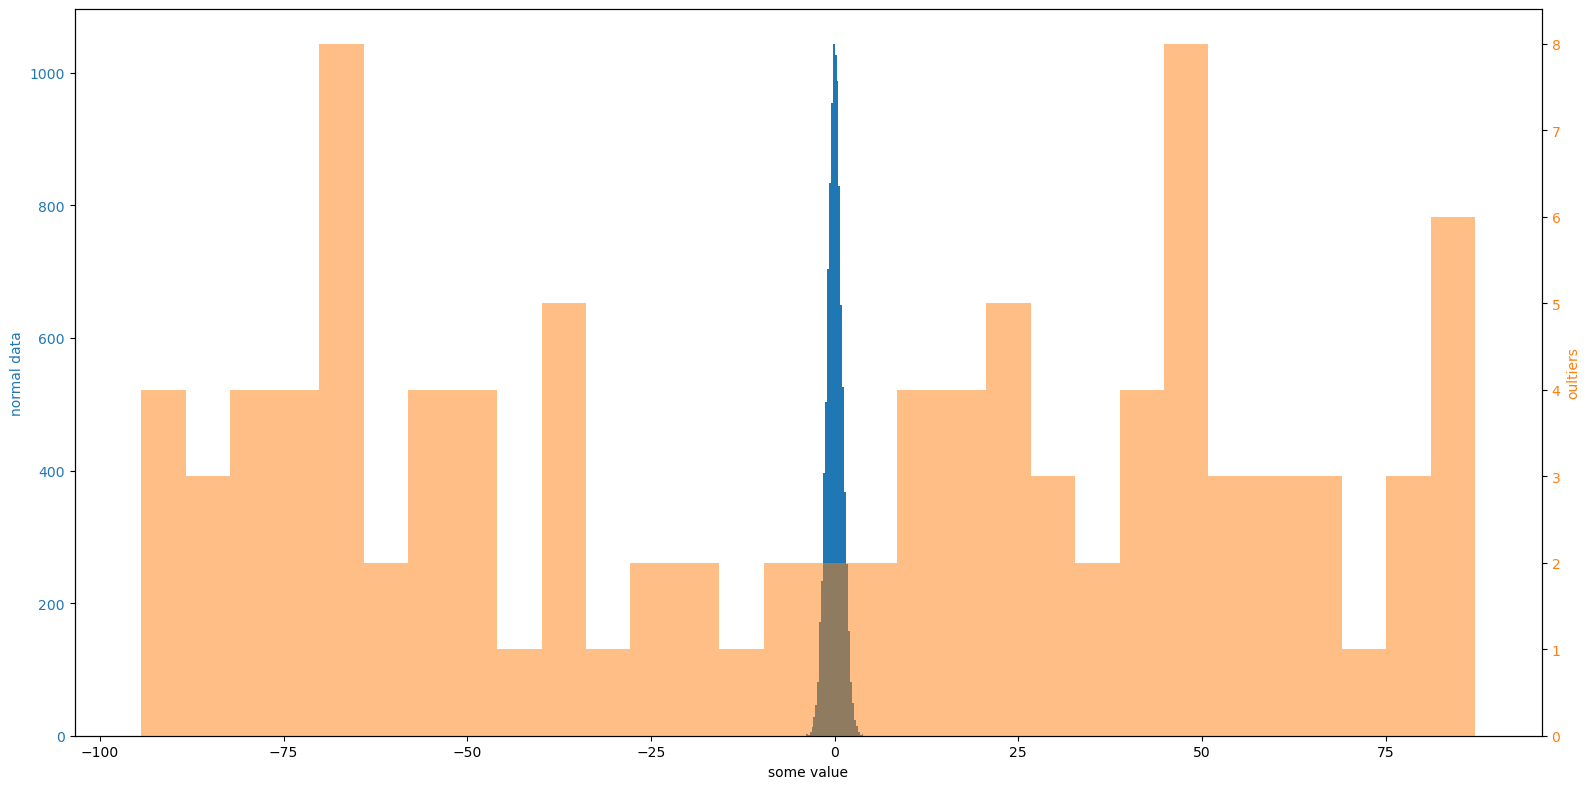

In [7]:
fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'tab:blue'
ax1.set_xlabel('some value')
ax1.set_ylabel('normal data', color=color)
ax1.hist(proper_data, 30)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('oultiers', color=color)  # we already handled the x-label with ax1
ax2.hist(anomalous_data, 30, color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [8]:
#preparing data for classifier
X = np.concatenate((proper_data, anomalous_data))


# making target data (we will use only for validation, not training)
y_proper = np.full((number_of_proper_data,), 1)
y_anomalous = np.full((number_of_anomal_data,), -1)
Y = np.concatenate((y_proper, y_anomalous))



Our data is prepared, let's train SVM classifier to detect anomalies. Hyperparameters was chosen using intuition.

In [9]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
# OCSVM hyperparameters
nu = 0.05
gamma = 2.0

# Fit the One-Class SVM
clf = OneClassSVM(gamma=gamma, kernel="sigmoid", nu=nu)
clf.fit(X)
y_pred = clf.predict(X)
print(f'Accuracy score is:{accuracy_score(Y, y_pred)}')

Accuracy score is:0.9498019801980198


Not bad, but we need to choose hyperparameters which will suit our model better. Also, I will add another metric - F1-score.
Here I will use new experimental method from scikit learn which can choose better hyperparameter set, based on chosen metric.

In [10]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import accuracy_score

param_grid = {  'gamma': [2, 1, 3, 0.1, 4.5, 5],
                'kernel': ["sigmoid", "rbf", "linear"],
                'nu':[0.05, 0.01, 0.02, 0.5, 0.005, 0.001, 0.0005]}

base_estimator = OneClassSVM()

sh = HalvingGridSearchCV(base_estimator, param_grid, scoring = make_scorer(f1_score)).fit(X, Y)
sh.best_estimator_

OneClassSVM(gamma=4.5, kernel='sigmoid', nu=0.001)

Now we have best estimator for our case. We can directly put it inside our classificator.

In [11]:
# Fit the One-Class SVM
clf = sh.best_estimator_
clf.fit(X)
y_pred = clf.predict(X)
print(f'Accuracy score is:{accuracy_score(Y, y_pred)}')
print(f'F1 score is:{f1_score(Y, y_pred)}')


Accuracy score is:0.9898019801980198
F1 score is:0.9948728159689382


Result is even better! 

Extra: while reading about one-class SVM I have noticed information about Local Outlier Factor (LOF). Which is more suitable for intrsion detection (Reference:https://en.wikipedia.org/wiki/Local_outlier_factor). Here my implementation.

In [12]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor()
y_pred=clf.fit_predict(X)
print(f'Accuracy score is:{accuracy_score(Y, y_pred)}')
print(f'F1 score is:{f1_score(Y, y_pred)}')


Accuracy score is:0.9905940594059406
F1 score is:0.9952658593711068


I want to say, that LOF is really better than one-class SVM and it doesn't need any setup.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDOneClassSVM.html

In [13]:
from sklearn import linear_model
clf1 = linear_model.SGDOneClassSVM(random_state=42)
y_pred=clf1.fit_predict(X)
print(f'Accuracy score is:{accuracy_score(Y, y_pred)}')
print(f'F1 score is:{f1_score(Y, y_pred)}')

Accuracy score is:0.6248514851485149
F1 score is:0.7677312572794703


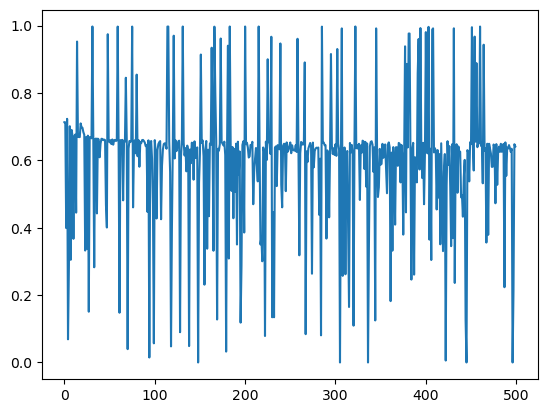

In [14]:
epochs = 500
learning_history = np.zeros(epochs)
for i in range(epochs):
    new_data = np.random.normal(loc=0.0, scale=1.0, size=[number_of_proper_data,1])
    clf1.partial_fit(new_data)
    y_pred = clf1.predict(X)
    learning_history[i]=f1_score(Y, y_pred)
plt.plot(learning_history);
    

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.7, random_state=42)

In [16]:

neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)
y_pred=neigh.predict(X_test)
print(f'Accuracy score is:{accuracy_score(y_test, y_pred)}')
print(f'F1 score is:{f1_score(y_test, y_pred)}')


Accuracy score is:0.9994342291371995
F1 score is:0.9997143673236218


k-NN shows more better picture, but need labels for data

In [17]:
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,
KNeighborsClassifier)
from sklearn.pipeline import Pipeline

nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)

print(nca_pipe.score(X_test, y_test))

0.9991513437057992


In [18]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
y_pred = kmeans.predict(X)
y_pred[y_pred > 0] = -1
y_pred[y_pred == 0] = 1
print(f'Accuracy score is:{accuracy_score(Y, y_pred)}')
print(f'F1 score is:{f1_score(Y, y_pred)}')

c:\Users\boskolk\AppData\Local\anaconda3\envs\Research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy score is:0.9975247524752475
F1 score is:0.9987515605493134


In [19]:
#preparing data for classifier
X_train = np.concatenate((proper_data, anomalous_data))

# making target data

y_proper = np.full((number_of_proper_data,), True)
y_anomalous = np.full((number_of_anomal_data,), False)
y_train = np.concatenate((y_proper, y_anomalous))

In [20]:
from sklearn.neural_network import MLPClassifier

MLP = MLPClassifier(random_state=42, max_iter=300, activation='logistic').fit(X_train, y_train)


In [21]:
print(f'score: {MLP.score(X_train, y_train)}')

score: 0.9995049504950495


In [22]:
#initializing blockchains
accel = Blockchain()
temp = Blockchain()


In [23]:
val_passed_counter = 0
val_failed_counter = 0
n_incoming = 1000

for i in range(n_incoming):

    incoming_data = ["a_01", "accel", rng.normal(loc=0.0, scale=20.0)]
    X_data_point = np.array(incoming_data[2]).reshape(-1, 1)
    result = filter(MLP,incoming_data)
    
    if stat_validate_result(result, incoming_data, mu, sigma):
        val_passed_counter +=1
        y_data_point = np.array(result).reshape(1,)
        #model.learn_one({ 0 : incoming_data[2]}, result)
        MLP.partial_fit(X_data_point, y_data_point)
        if not result:
            print(f"Skipping {i}-th data point...")
        else:
            accel.new_data(incoming_data[0],incoming_data[1],incoming_data[2])
            accel.new_block(42)
            if accel.verify(verbose=False):
                print(f'Accelerometer info from {incoming_data[0]} has been added successfully!')
    else:
        val_failed_counter +=1
        y_data_point = np.array(not result).reshape(1,)
        #model.learn_one({ 0 : incoming_data[2]}, not result)
        MLP.partial_fit(X_data_point, y_data_point)
        print(f"Skipping {i}-th data point...")

-19.369672939237912 and [False] are validated
Skipping 0-th data point...
-27.63538377135408 and [False] are validated
Skipping 1-th data point...
15.401002178351717 and [False] are validated
Skipping 2-th data point...
30.122944815498933 and [False] are validated
Skipping 3-th data point...
-8.77699980956343 and [False] are validated
Skipping 4-th data point...
-22.78123015232702 and [False] are validated
Skipping 5-th data point...
-49.16338861098037 and [False] are validated
Skipping 6-th data point...
-19.615296873250752 and [False] are validated
Skipping 7-th data point...
-2.273136849980804 and [ True] are equal
Accelerometer info from a_01 has been added successfully!
31.982464816734684 and [False] are validated
Skipping 9-th data point...
13.46267384465937 and [False] are validated
Skipping 10-th data point...
6.10170809413506 and [False] are validated
Skipping 11-th data point...
-8.002393226022619 and [False] are validated
Skipping 12-th data point...
-11.663314345119126 and 

In [24]:
print(f'score: {val_passed_counter/ n_incoming}')

score: 0.986


In [25]:
# making target data (we will use only for validation, not training)
y_proper = np.full((number_of_proper_data,), 0)
y_anomalous = np.full((number_of_anomal_data,), 1)
Y = np.concatenate((y_proper, y_anomalous))

In [26]:
from river import anomaly
from river import compose
from river import datasets
from river import metrics
from river import preprocessing

model = anomaly.QuantileFilter(
     anomaly.OneClassSVM(nu=0.2),
     q=0.995)
auc = metrics.ROCAUC()

In [27]:
data = stream.iter_array(X=X_train, y=Y, shuffle=True)
evaluate.progressive_val_score(
     dataset=data,
     model=model,
     metric=auc,
     print_every=1000
 )

[1,000] ROCAUC: 56.48%
[2,000] ROCAUC: 59.14%
[3,000] ROCAUC: 58.61%
[4,000] ROCAUC: 58.78%
[5,000] ROCAUC: 58.50%
[6,000] ROCAUC: 59.99%
[7,000] ROCAUC: 60.43%
[8,000] ROCAUC: 62.18%
[9,000] ROCAUC: 61.37%
[10,000] ROCAUC: 61.23%
[10,100] ROCAUC: 61.23%


ROCAUC: 61.23%

In [28]:
svm_acc = metrics.Accuracy()
for i in range(n_incoming):

    incoming_data = ["a_01", "accel", rng.normal(loc=0.0, scale=20.0)]
    X_data_point = np.array(incoming_data[2]).reshape(-1, 1)
    x = { 0 : incoming_data[2]}
    score = model.score_one(x)
    is_anomaly = model.classify(score)
    ground_truth = validate_result(incoming_data, mu, sigma)
    model = model.learn_one(x)
    auc = auc.update(ground_truth, is_anomaly)
    

auc

ROCAUC: 53.45%

In [29]:
KNN = neighbors.KNNRegressor(n_neighbors=3, window_size=100)
metric = metrics.R2()

evaluate.progressive_val_score(dataset=data,
                               model=KNN,
                               metric=metric,
                               print_every=1000)

R2: 0.

In [30]:
accuracy = metrics.Accuracy()
for i in range(n_incoming):

    incoming_data = ["a_01", "accel", rng.normal(loc=0.0, scale=20.0)]
    x = { 0 : incoming_data[2]}
    is_anomaly = KNN.predict_one(x)
    ground_truth = validate_result(incoming_data, mu, sigma)
    KNN = KNN.learn_one(x, ground_truth)
    accuracy = accuracy.update(ground_truth, is_anomaly)
    metric = metric.update(ground_truth, is_anomaly)

In [31]:
metric

R2: 0.841996

In [32]:
accuracy

Accuracy: 94.60%

In [33]:
data = stream.iter_array(X=X_train, y=Y, shuffle=True)

In [34]:
from river.datasets import synth
from river import evaluate
from river import metrics
from river import tree

gen = synth.Agrawal(classification_function=0, seed=42)
# Take 1000 instances from the infinite data generator

tree = tree.HoeffdingTreeClassifier(
    grace_period=100,
    delta=1e-5,
)


evaluate.progressive_val_score(data, tree, metrics.Accuracy(), print_every=1000)

[1,000] Accuracy: 99.00%
[2,000] Accuracy: 99.35%
[3,000] Accuracy: 99.47%
[4,000] Accuracy: 99.45%
[5,000] Accuracy: 99.46%
[6,000] Accuracy: 99.43%
[7,000] Accuracy: 99.49%
[8,000] Accuracy: 99.55%
[9,000] Accuracy: 99.60%
[10,000] Accuracy: 99.63%
[10,100] Accuracy: 99.63%


Accuracy: 99.63%

In [35]:
k_means = cluster.KMeans(n_clusters=2, halflife=0.1, sigma=3, seed=42)

In [36]:
init_prediction = np.zeros((number_of_proper_data+number_of_anomal_data,), dtype=int)
for i, (x, _) in enumerate(stream.iter_array(X_train)):
    k_means = k_means.learn_one(x)
    init_prediction [i] = k_means.predict_one(x)

In [37]:
k_means_acc = metrics.Accuracy()

for i in range(n_incoming):

    incoming_data = ["a_01", "accel", rng.normal(loc=0.0, scale=20.0)]
    x = { 0 : incoming_data[2]}
    is_anomaly = k_means.learn_predict_one(x)
    ground_truth = validate_result(incoming_data, mu, sigma)
    k_means_acc = k_means_acc.update(ground_truth, is_anomaly)

In [38]:
k_means_acc

Accuracy: 49.20%

In [39]:
dbstream = cluster.DBSTREAM(clustering_threshold = 3,
                             fading_factor = 0.05,
                             intersection_factor = 0.5)

In [40]:
for i, (x, _) in enumerate(stream.iter_array(X_train)):
    #print(x)
    dbstream = dbstream.learn_one(x)

In [41]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=2).fit(X)

In [42]:
dbstream_acc = metrics.Accuracy()

n = range(n_incoming)
ground_truth = np.zeros((n_incoming,), dtype=int)
prediction = np.zeros((n_incoming,), dtype=int)
offline_prediction = np.zeros((n_incoming,), dtype=int)
score = 0
total_true = 0
for i in n:

    incoming_data = ["a_01", "accel", rng.normal(loc=0.0, scale=20.0)]
    x = { 0 : incoming_data[2]}
    dbstream = dbstream.learn_one(x)
    #offline_prediction[i] = clustering.fit_predict(np.array(incoming_data[2]).reshape(-1, 1))
    #print(offline_prediction[i])
    ground_truth[i] = validate_result(incoming_data, mu, sigma)
    prediction[i] = dbstream.predict_one(x)
    if ground_truth[i]==0:
        total_true += 1
        if prediction[i]==0:
            score += 1
    
score = score/total_true
score

0.05357142857142857

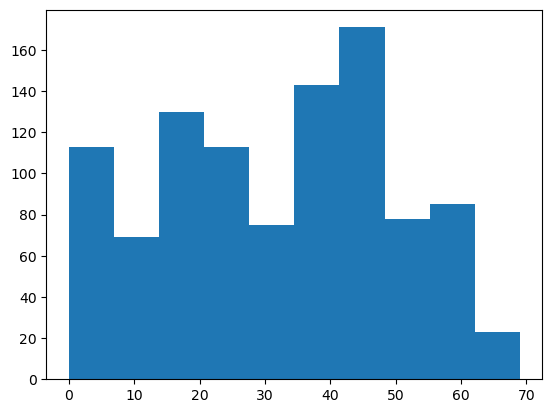

In [43]:
plt.hist(prediction);

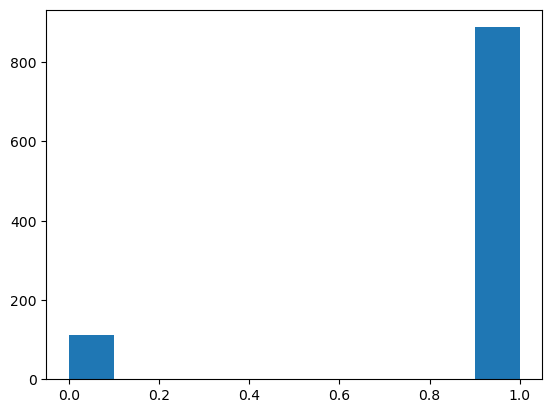

In [44]:
plt.hist(ground_truth);

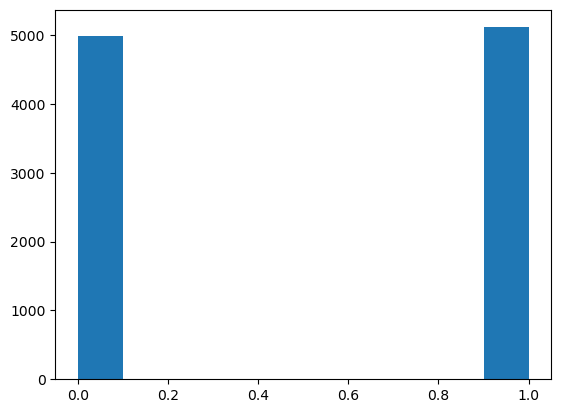

In [45]:
plt.hist(init_prediction);

In [2]:
def separation(data):
    f_40 = round(data.shape[0] * 0.4)
    l_40 = round(data.shape[0] - f_40)
    data_f = data.loc[0 : f_40 - 1]    # -1 тк 0 индекс добавляет лишнюю строку
    data_l = data.loc[l_40 : data.shape[0]]
    
    data_f['target'] = 1
    data_l['target'] = 0
    
    return pd.concat([data_f, data_l])

In [13]:
for i in range(1,8):
    print(i)

1
2
3
4
5
6
7


In [3]:
final_dataset = np.zeros((1,4))
for i in range(1,8):
    trial = pd.read_csv(f'cube_megax_defect_{i}.csv', header=None)
    trial_features = separation(trial).to_numpy()
    final_dataset = np.concatenate((final_dataset,trial_features))
final_dataset.shape

C:\Users\boskolk\AppData\Local\Temp\ipykernel_36736\3196931182.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f['target'] = 1
C:\Users\boskolk\AppData\Local\Temp\ipykernel_36736\3196931182.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_l['target'] = 0
C:\Users\boskolk\AppData\Local\Temp\ipykernel_36736\3196931182.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

(10607, 4)

In [4]:
# Extract the targets
extracted_targets = final_dataset[1:, 3].astype(int)
extracted_features = final_dataset[1:, :3]

print(extracted_features)

[[-0.81  -9.56   0.299]
 [-0.796 -9.55   0.328]
 [-0.744 -9.55   0.329]
 ...
 [-0.762 -9.56   0.2  ]
 [-0.727 -9.56   0.228]
 [-0.734 -9.56   0.259]]


In [46]:
random_state = 0
rng = np.random.RandomState(random_state)
# Generate some example data
X, labels, centers = make_blobs(n_samples=20000, centers=1, random_state=random_state, n_features = 3, return_centers=True)
bias = 5
anomalous_data, ano_lbl = make_blobs(n_samples=2000, centers=[[centers[0][0], centers[0][1]-bias, centers[0][2]]], random_state=random_state, n_features = 3)
X_inj=np.concatenate((X, anomalous_data), axis=0)
labels_inj=np.concatenate((labels, np.ones(2000,)), axis=0)
labels_inj = labels_inj.reshape(22000,1)
data = np.concatenate((X_inj, labels_inj), axis=1)
data = rng.permutation(data)
X_inj_rand = data[:, :3]
labels_inj_rand = data[:, 3]

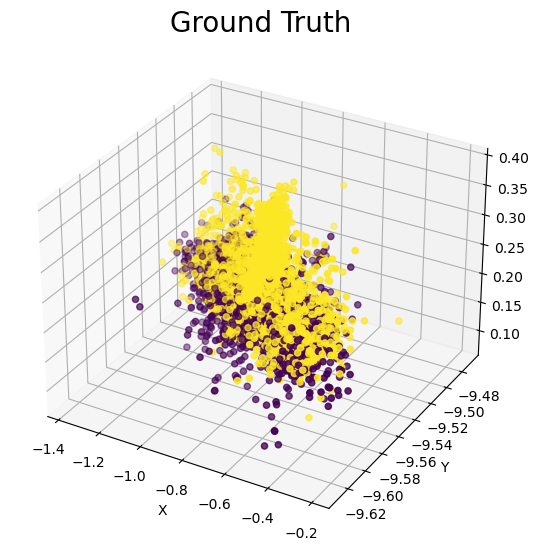

In [23]:
fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ground Truth',fontsize = 20)
ax.scatter(extracted_features[:, 0], extracted_features[:, 1], extracted_features[:, 2], c=extracted_targets)
plt.show()

In [5]:
X_inj_rand = extracted_features
labels_inj_rand = extracted_targets

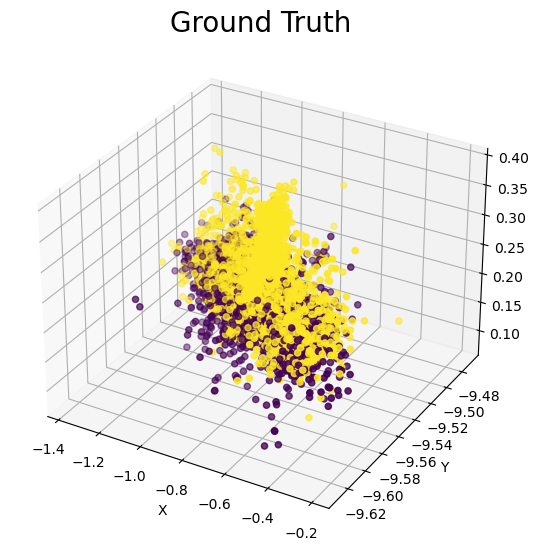

In [25]:
fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ground Truth',fontsize = 20)
ax.scatter(X_inj[:, 0], X_inj[:, 1], X_inj[:, 2], c=labels_inj)
plt.show()

Accuracy 50.0 %


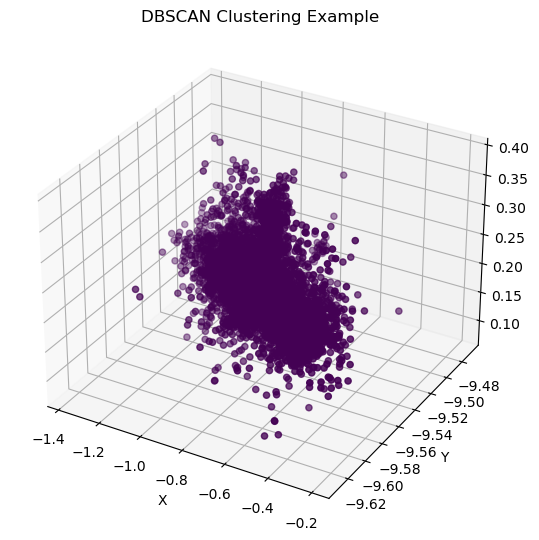

In [26]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.515, min_samples=5)
y_pred = dbscan.fit_predict(X_inj)
fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering Example')
ax.scatter(X_inj[:, 0], X_inj[:, 1], X_inj[:, 2], c=y_pred)
print(f'Accuracy {accuracy_score(y_pred, labels_inj)*100} %')
plt.show()

Accuracy 50.0 %


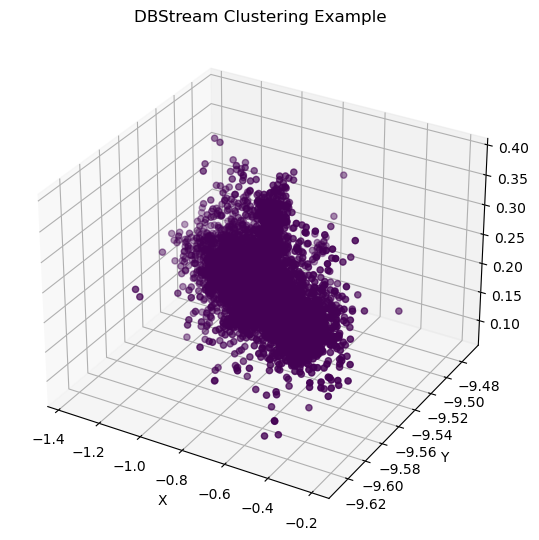

In [27]:
dbstream_exp = cluster.DBSTREAM(clustering_threshold = 5)

for i, (x, _) in enumerate(stream.iter_array(X_inj)):
    dbstream_exp = dbstream_exp.learn_one(x)
    y_pred[i] = dbstream_exp.predict_one(x)

fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBStream Clustering Example')
ax.scatter(X_inj[:, 0], X_inj[:, 1], X_inj[:, 2], c=y_pred)
print(f'Accuracy {accuracy_score(y_pred, labels_inj)*100} %')
plt.show()

Accuracy 50.0 %


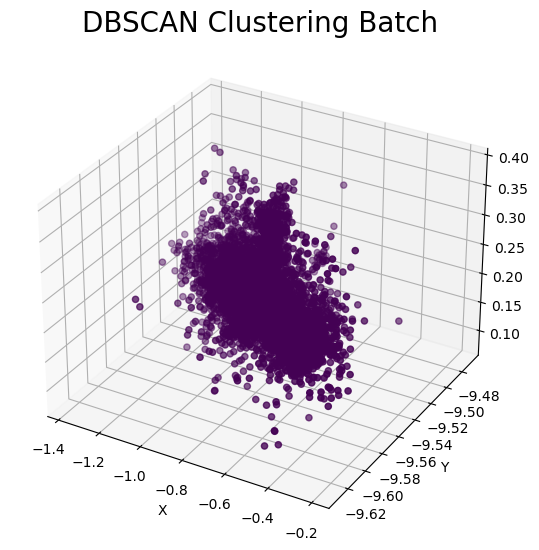

1.69 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [30]:
%%timeit -r 1 -n 1
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.55)
y_pred = dbscan.fit_predict(X_inj_rand)
fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering Batch',fontsize = 20)
ax.scatter(X_inj_rand[:, 0], X_inj_rand[:, 1], X_inj_rand[:, 2], c=y_pred)
print(f'Accuracy {accuracy_score(y_pred, labels_inj_rand)*100} %')
plt.show()

Accuracy 50.0 %


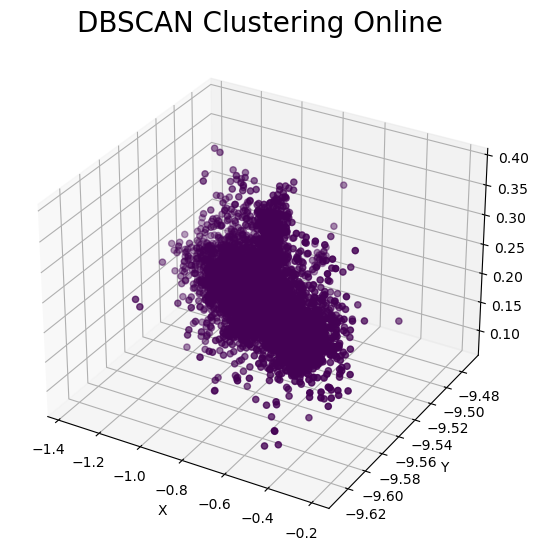

899 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [76]:
%%timeit -r 1 -n 1
dbstream_exp = cluster.DBSTREAM(clustering_threshold = 0.9)

for i, (x, _) in enumerate(stream.iter_array(X_inj_rand)):
    dbstream_exp = dbstream_exp.learn_one(x)
    y_pred[i] = dbstream_exp.predict_one(x)
fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering Online',fontsize = 20)
ax.scatter(X_inj_rand[:, 0], X_inj_rand[:, 1], X_inj_rand[:, 2], c=y_pred)
print(f'Accuracy {round(accuracy_score(y_pred, labels_inj_rand)*100,2)} %')
plt.show()

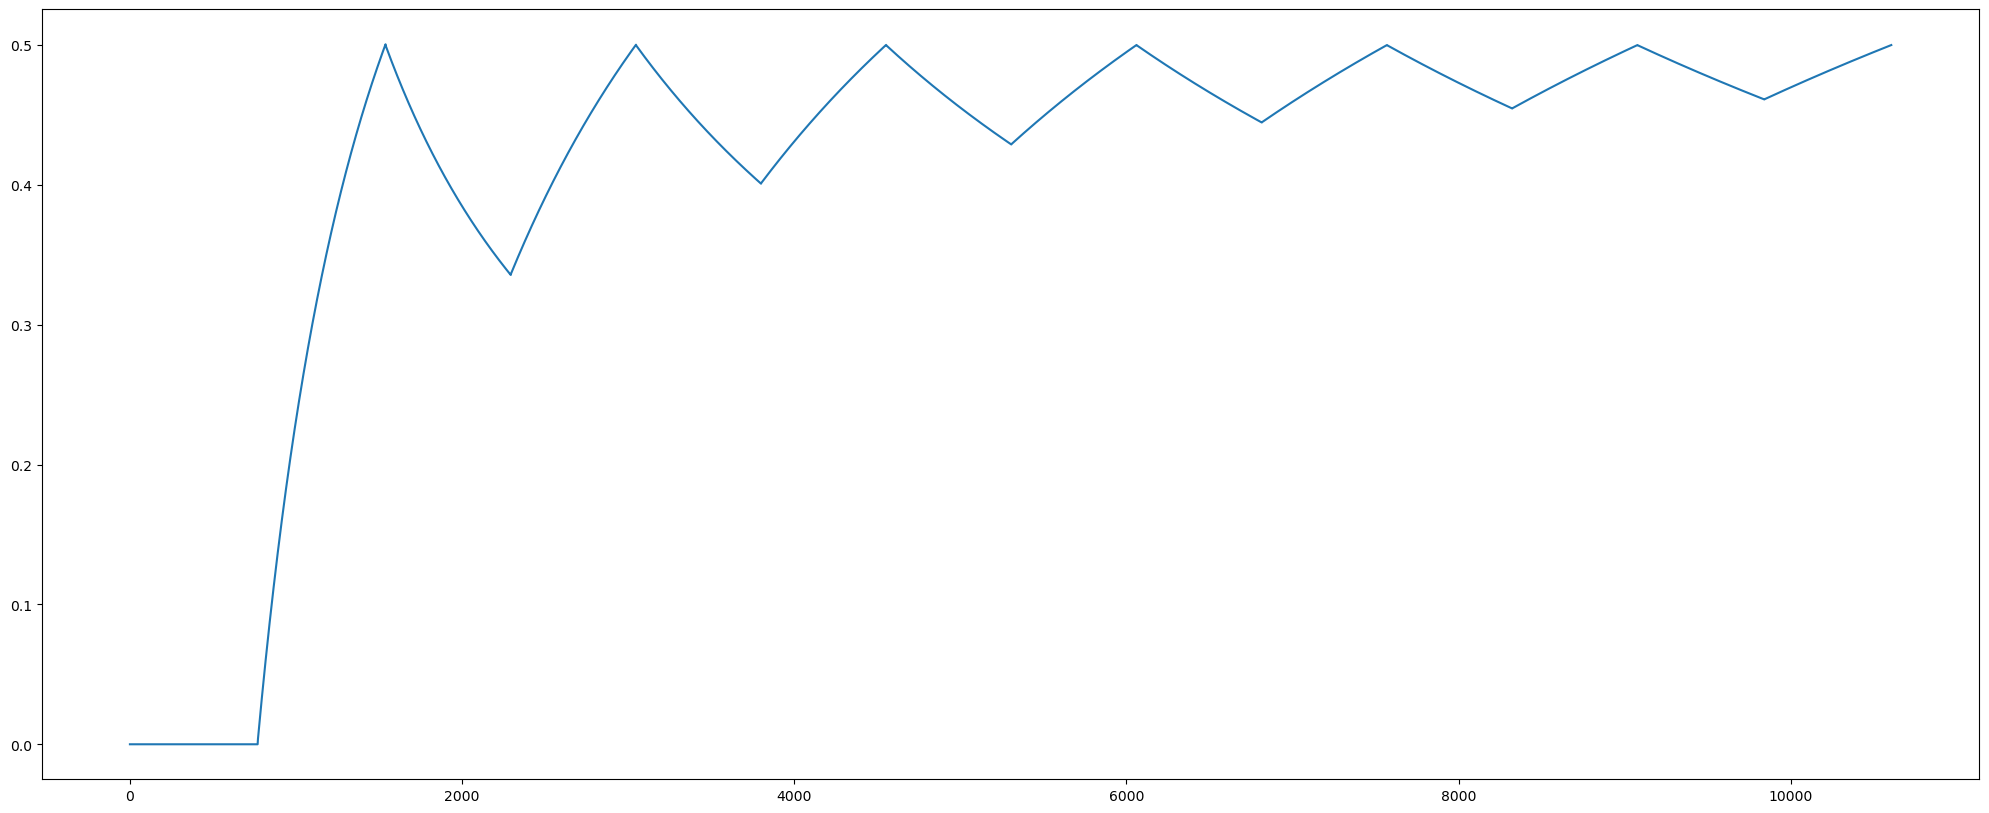

In [77]:
acc_cumul_db = np.zeros_like(labels_inj_rand, dtype = float)
counter = 0
for i in range(len(y_pred)):

    if y_pred[i] == labels_inj_rand[i]:
        counter +=1
    acc_cumul_db[i] = (counter+(y_pred[i] == labels_inj_rand[i])*1)/(i+1)
plt.figure(figsize= (25,10))
plt.plot(acc_cumul_db)

Accuracy 50.0 %


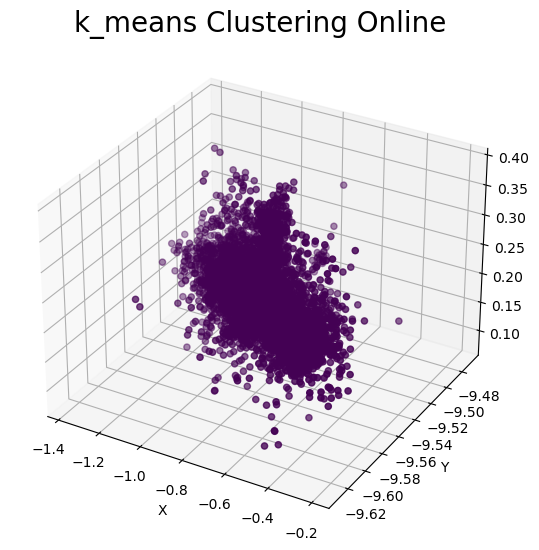

589 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [73]:
%%timeit -r 1 -n 1
k_means = cluster.KMeans(n_clusters=2, seed=42)

for i, (x, _) in enumerate(stream.iter_array(X_inj_rand)):
    k_means = k_means.learn_one(x)
    y_pred[i] = k_means.predict_one(x)
fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('k_means Clustering Online',fontsize = 20)
ax.scatter(X_inj_rand[:, 0], X_inj_rand[:, 1], X_inj_rand[:, 2], c=y_pred)
print(f'Accuracy {round(accuracy_score(y_pred, labels_inj_rand)*100,2)} %')
plt.show()

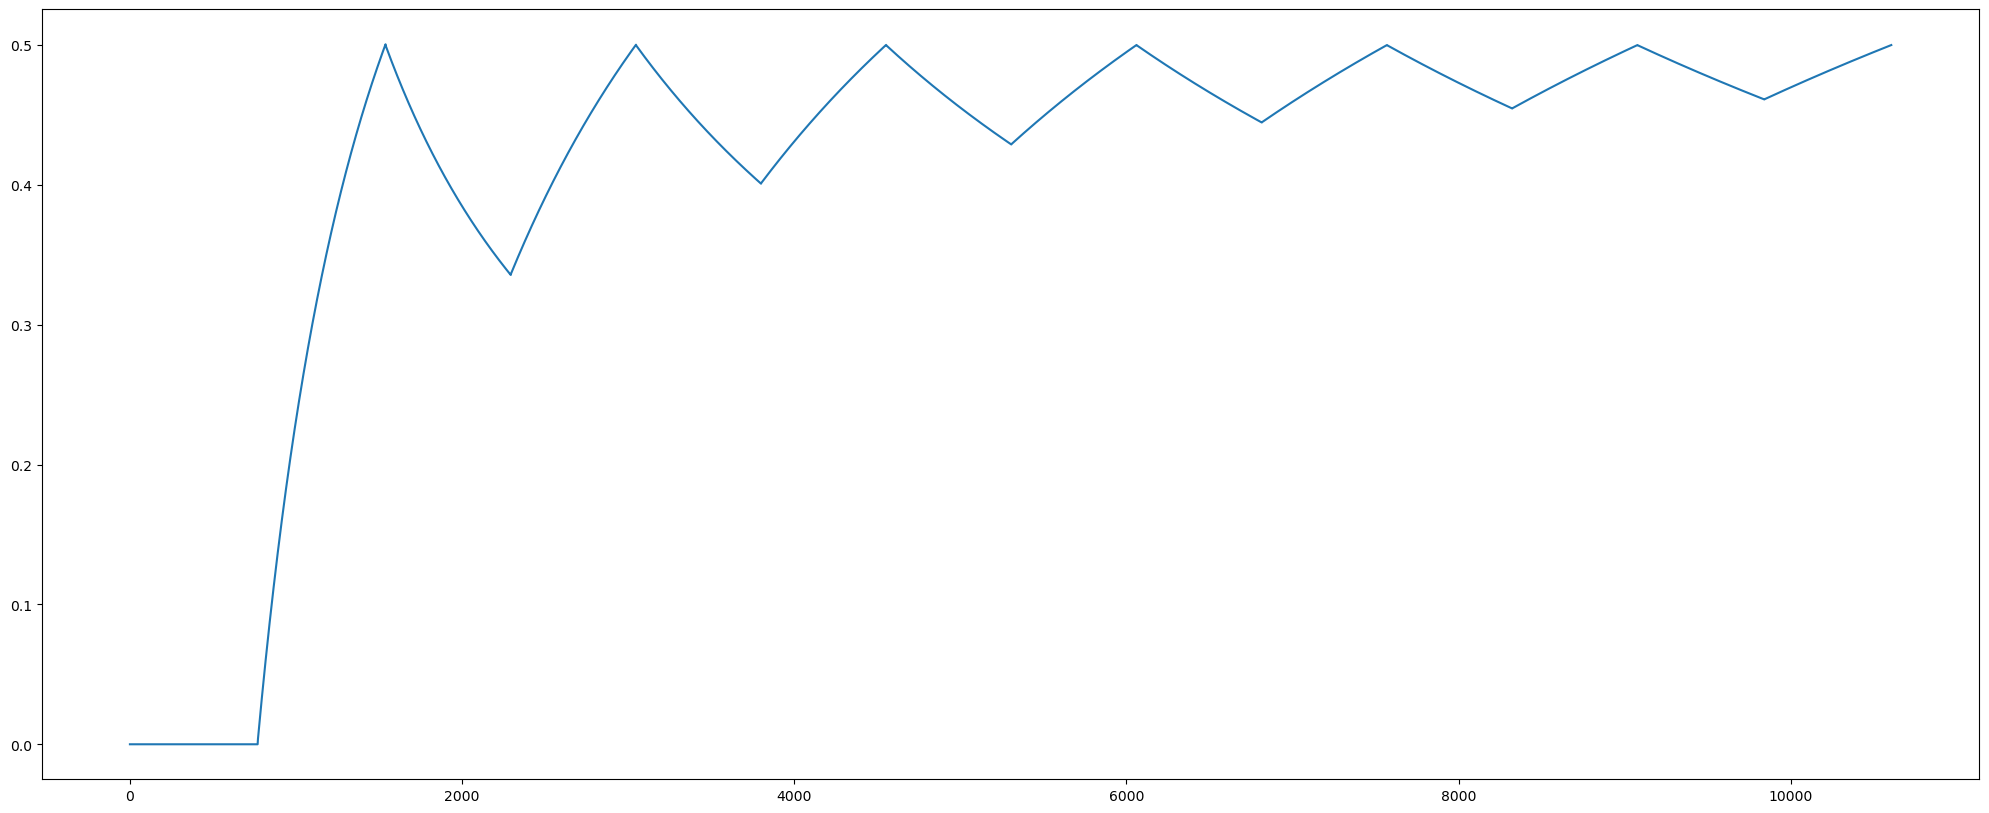

In [74]:
acc_cumul_k_means = np.zeros_like(labels_inj_rand, dtype = float)
counter = 0
for i in range(len(y_pred)):
    if y_pred[i] == labels_inj_rand[i]:
        counter +=1
    acc_cumul_k_means[i] = (counter+(y_pred[i] == labels_inj_rand[i])*1)/(i+1)
plt.figure(figsize= (25,10))
plt.plot(acc_cumul_k_means)

Accuracy 48.89 %


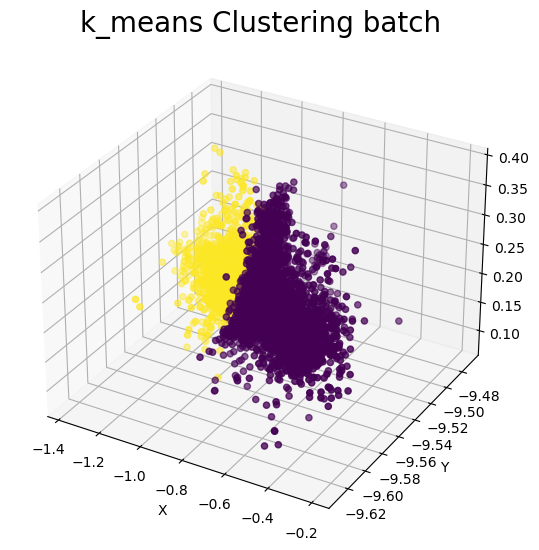

553 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [71]:

%%timeit -r 1 -n 1
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X_inj_rand)
y_pred = kmeans.labels_
fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('k_means Clustering batch',fontsize = 20)
ax.scatter(X_inj_rand[:, 0], X_inj_rand[:, 1], X_inj_rand[:, 2], c=y_pred)
print(f'Accuracy {round(accuracy_score(y_pred, labels_inj_rand)*100,2)} %')
plt.show()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X_inj_rand, labels_inj_rand, test_size=0.4, random_state=42)

In [6]:
%%timeit -r 1 -n 1
MLP_batch = MLPClassifier(activation='logistic',random_state=42).fit(X_train,y_train)
y_pred = MLP_batch.predict(X_test)
fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('MLP batch',fontsize = 20)
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_pred)
print(f'Accuracy {round(accuracy_score(y_pred, y_test)*100,2)} %')
plt.show()

NameError: name 'X_train' is not defined

In [7]:
from river import linear_model as lm

Accuracy 99.8 %


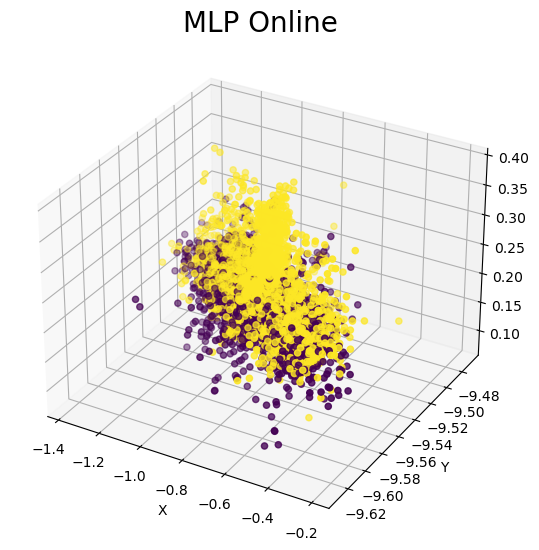

In [78]:
acc_cumul = np.zeros_like(labels_inj_rand)
mlp_exp = lm.Perceptron()
y_pred = np.zeros_like(labels_inj_rand, dtype =float)
for i, (x, y) in enumerate(stream.iter_array(X_inj_rand, labels_inj_rand)):
    y_pred[i] = mlp_exp.predict_one(x)
    if i != 0:
        acc_cumul[i] = (acc_cumul[i-1]+((y_pred[i] == labels_inj_rand[i])*1))/(i+1)
    
    
    mlp_exp = mlp_exp.learn_one(x,y)
fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('MLP Online',fontsize = 20)
ax.scatter(X_inj_rand[:, 0], X_inj_rand[:, 1], X_inj_rand[:, 2], c=y_pred)
print(f'Accuracy {round(accuracy_score(np.nan_to_num(y_pred), labels_inj_rand)*100,2)} %')
plt.show()

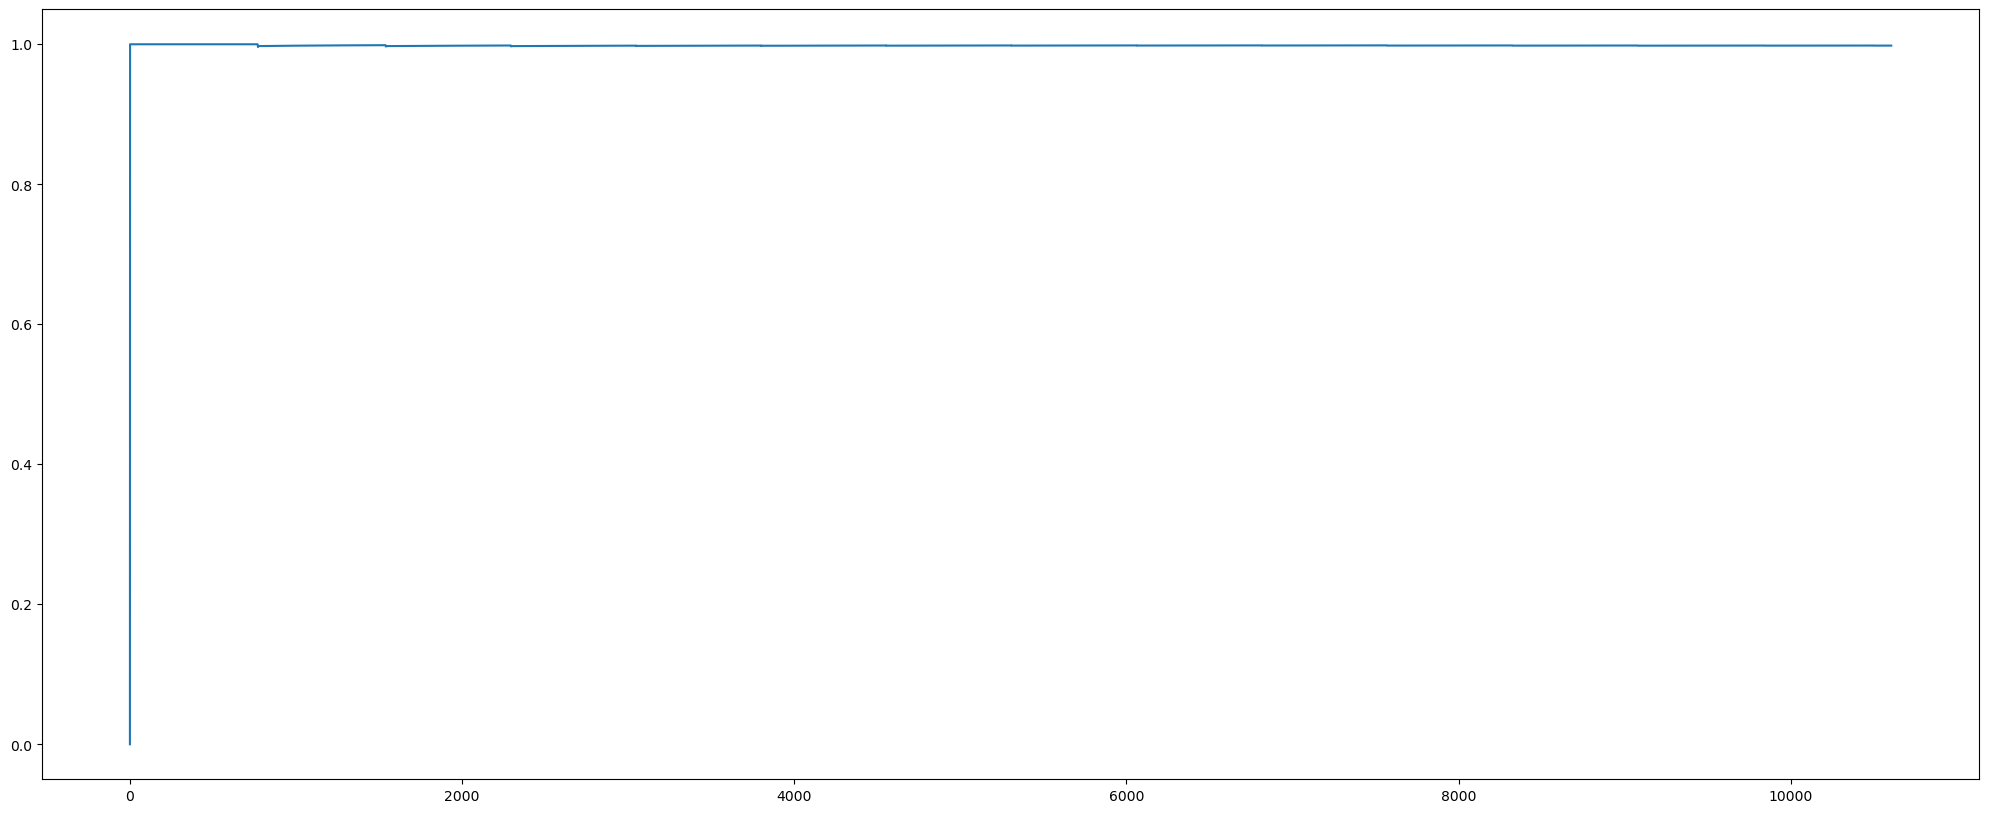

In [79]:
acc_cumul_mlp = np.zeros_like(labels_inj_rand, dtype = float)
counter = 0
for i in range(len(y_pred)):

    if y_pred[i] == labels_inj_rand[i]:
        counter +=1
    acc_cumul_mlp[i] = (counter+(y_pred[i] == labels_inj_rand[i])*1)/(i+1)
plt.figure(figsize= (25,10))
plt.plot(acc_cumul_mlp)

In [64]:
%%timeit -r 1 -n 1
neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
y_pred = neigh.predict(X_test)
fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('KNN batch',fontsize = 20)
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_pred)
print(f'Accuracy {round(accuracy_score(y_pred, y_test)*100,2)} %')
plt.show()

NameError: name 'X_train' is not defined

In [41]:
from river import neighbors

Accuracy 59.43 %


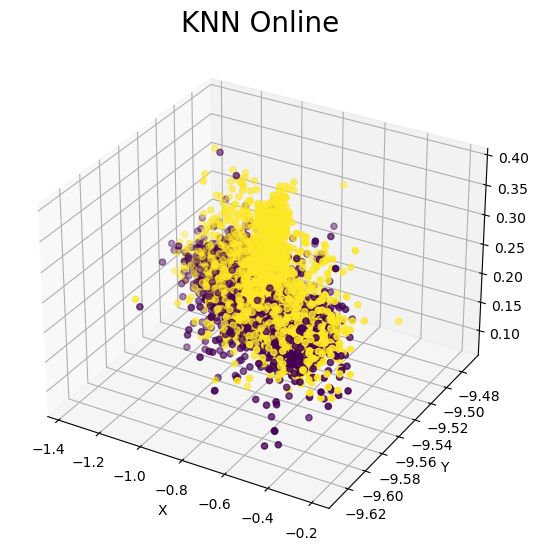

In [90]:

knn_exp = neighbors.KNNClassifier(n_neighbors=3)
y_pred = np.zeros_like(labels_inj_rand, dtype = float)
for i, (x, y) in enumerate(stream.iter_array(X_inj_rand, labels_inj_rand)):
    y_pred[i] = np.nan_to_num(knn_exp.predict_one(x))
    knn_exp = knn_exp.learn_one(x,y)
fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('KNN Online',fontsize = 20)
ax.scatter(X_inj_rand[:, 0], X_inj_rand[:, 1], X_inj_rand[:, 2], c=y_pred)
print(f'Accuracy {round(accuracy_score(np.nan_to_num(y_pred), labels_inj_rand)*100,2)} %')
plt.show()

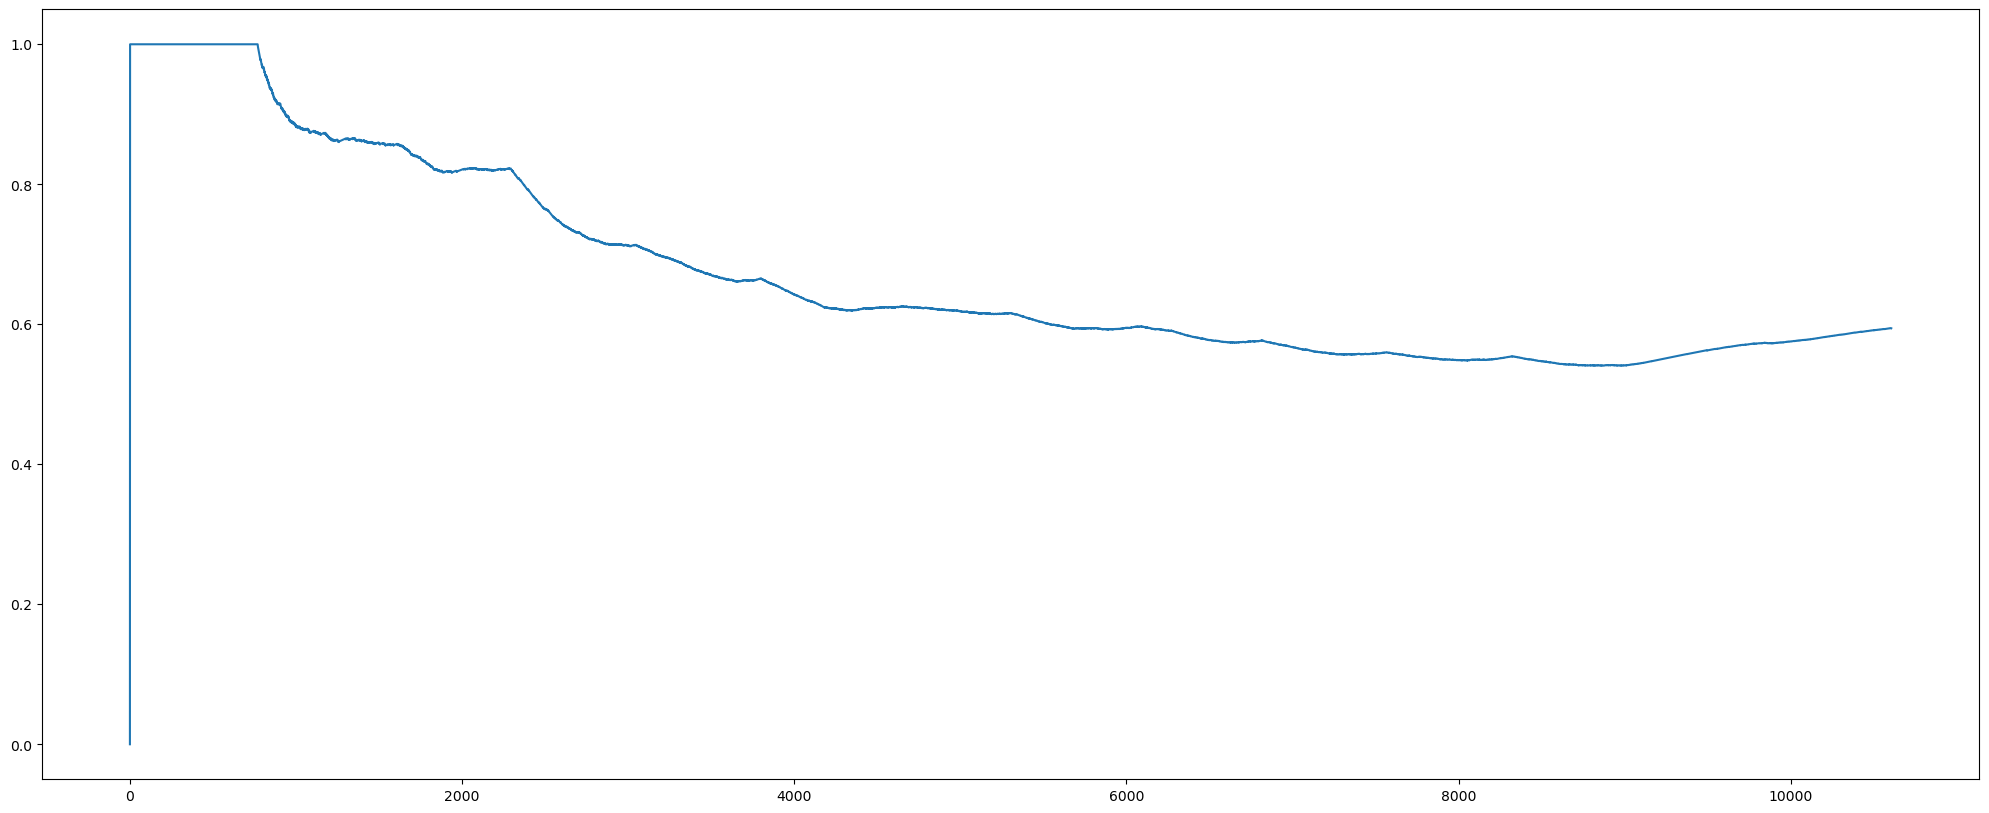

In [91]:
acc_cumul_knn = np.zeros_like(labels_inj_rand, dtype = float)
counter = 0
for i in range(len(y_pred)):

    if y_pred[i] == labels_inj_rand[i]:
        counter +=1
    acc_cumul_knn[i] = (counter+(y_pred[i] == labels_inj_rand[i])*1)/(i+1)
plt.figure(figsize= (25,10))
plt.plot(acc_cumul_knn)

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [89]:
%%timeit -r 1 -n 1
clf = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
y_pred = clf.predict(X_test)
fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DecisionTreeClassifier batch',fontsize = 20)
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_pred)
print(f'Accuracy {round(accuracy_score(y_pred, y_test)*100,2)} %')
plt.show()

NameError: name 'DecisionTreeClassifier' is not defined

In [68]:
from river import tree

Accuracy 72.29 %


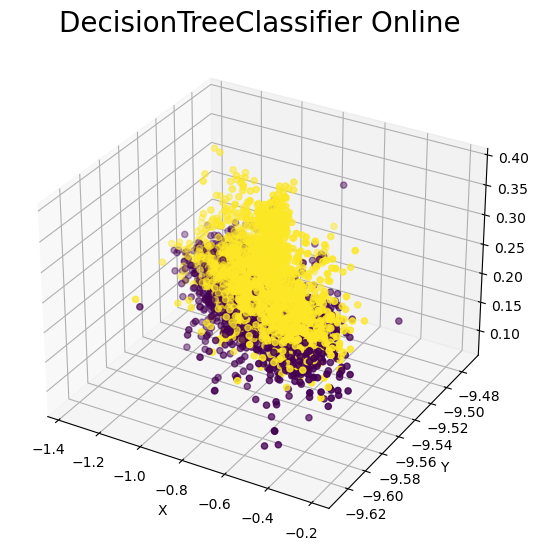

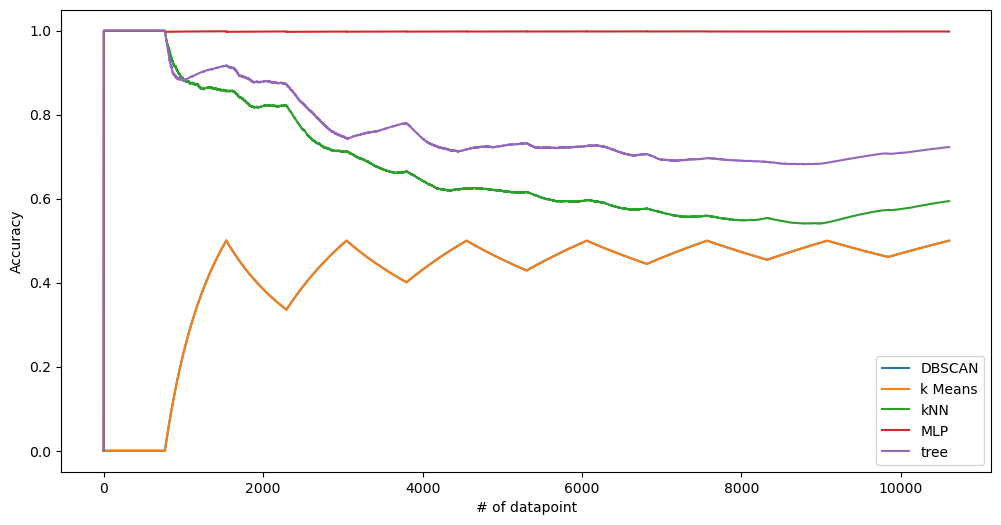

9.93 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [105]:
%%timeit -r 1 -n 1
tree_exp = tree.ExtremelyFastDecisionTreeClassifier()
y_pred = np.zeros_like(labels_inj_rand, dtype =float)
for i, (x, y) in enumerate(stream.iter_array(X_inj_rand, labels_inj_rand)):
    y_pred[i] = tree_exp.predict_one(x)
    tree_exp = tree_exp.learn_one(x,y)
fig = plt.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DecisionTreeClassifier Online',fontsize = 20)
ax.scatter(X_inj_rand[:, 0], X_inj_rand[:, 1], X_inj_rand[:, 2], c=y_pred)
print(f'Accuracy {round(accuracy_score(np.nan_to_num(y_pred), labels_inj_rand)*100,2)} %')
plt.show()

acc_cumul_tree = np.zeros_like(labels_inj_rand, dtype = float)
counter = 0
for i in range(len(y_pred)):

    if y_pred[i] == labels_inj_rand[i]:
        counter +=1
    acc_cumul_tree[i] = (counter+(y_pred[i] == labels_inj_rand[i])*1)/(i+1)
plt.figure(figsize= (12,6))

# Plot the data
plt.plot(acc_cumul_db, label="DBSCAN")
plt.plot(acc_cumul_k_means, label="k Means")
plt.plot(acc_cumul_knn, label="kNN")
plt.plot(acc_cumul_mlp, label="MLP")
plt.plot(acc_cumul_tree, label="tree")
plt.xlabel('# of datapoint')
plt.ylabel('Accuracy')

# Add a legend
plt.legend()

# Show the plot
plt.show()

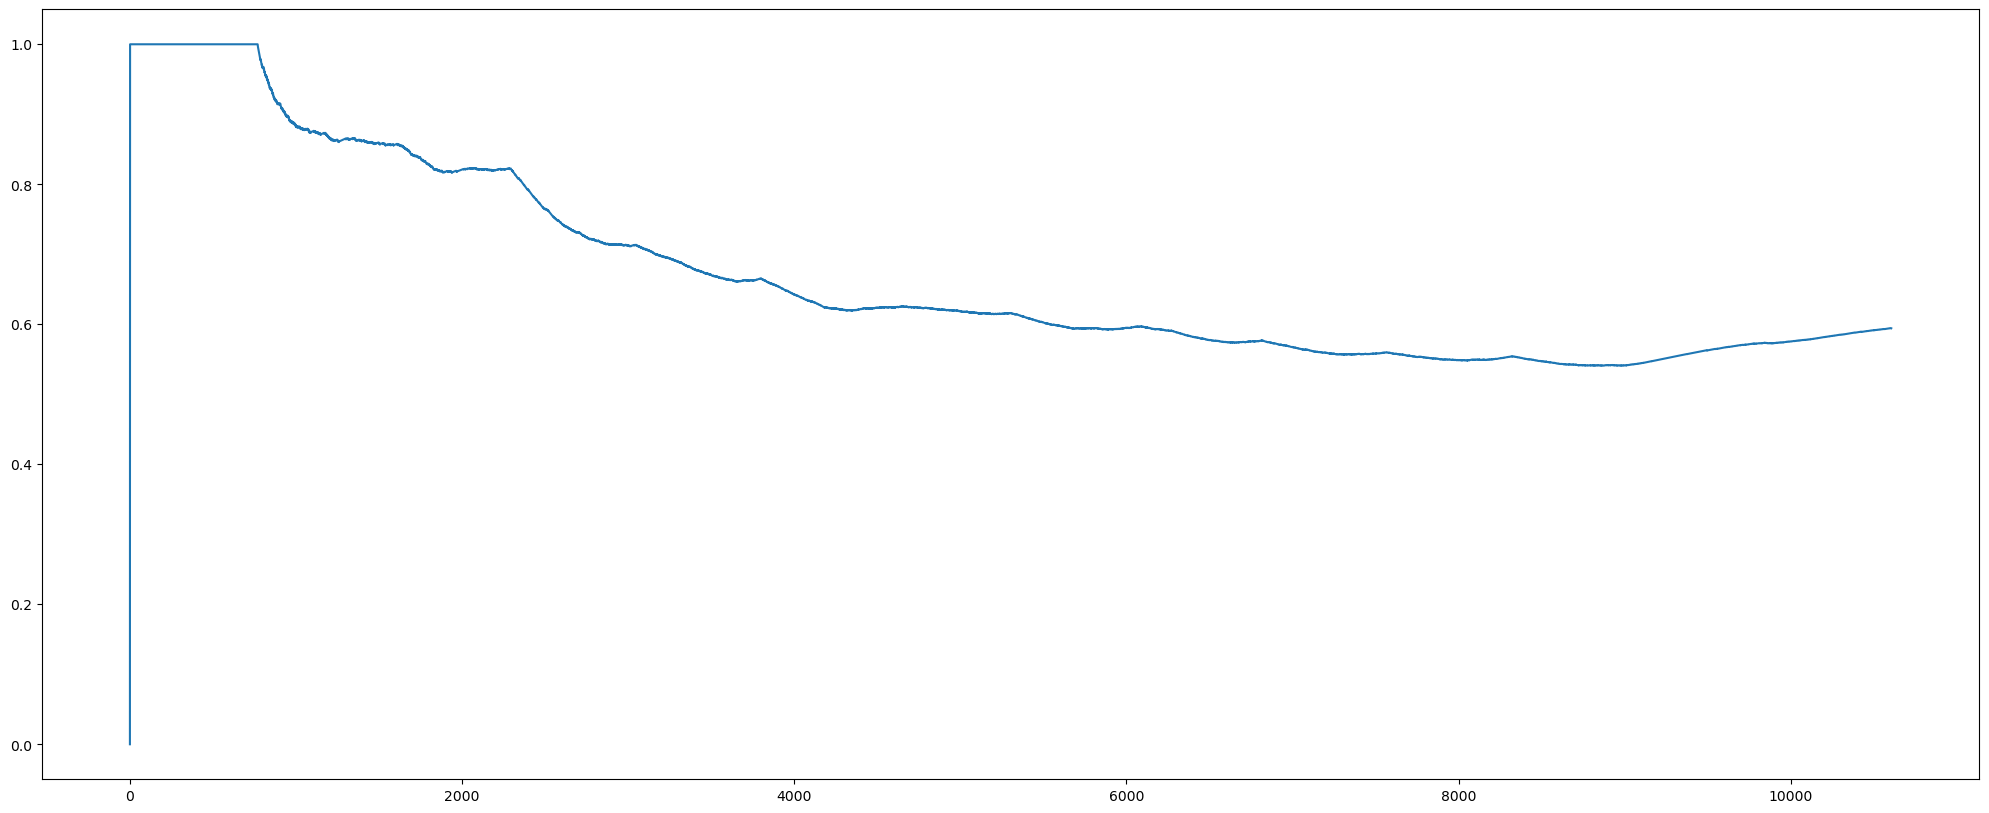

In [98]:
acc_cumul_tree = np.zeros_like(labels_inj_rand, dtype = float)
counter = 0
for i in range(len(y_pred)):

    if y_pred[i] == labels_inj_rand[i]:
        counter +=1
    acc_cumul_tree[i] = (counter+(y_pred[i] == labels_inj_rand[i])*1)/(i+1)
plt.figure(figsize= (25,10))
plt.plot(acc_cumul_tree)

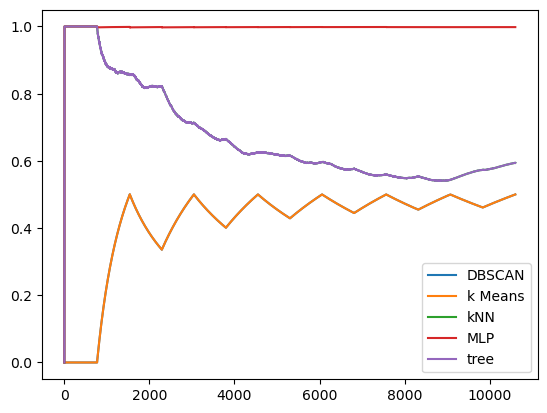

In [92]:
# Plot the data
plt.plot(acc_cumul_db, label="DBSCAN")
plt.plot(acc_cumul_k_means, label="k Means")
plt.plot(acc_cumul_knn, label="kNN")
plt.plot(acc_cumul_mlp, label="MLP")
plt.plot(acc_cumul_tree, label="tree")

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dense, Dropout, Flatten

class TimeSeriesTransformer(tf.keras.Model):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout):
        super(TimeSeriesTransformer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(
            key_dim=d_model, num_heads=nhead, dropout=dropout
        )
        self.fc = Dense(units=input_dim, activation="relu")
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout)
        self.flatten = Flatten()  # Add Flatten layer

    def call(self, x):
        attn_output = self.multi_head_attention(x, x)
        attn_output = self.dropout(attn_output)
        x = self.layernorm1(x + attn_output)
        fc_output = self.fc(x)  # Removed 'self.flatten' here
        fc_output = self.dropout(fc_output)
        output = self.layernorm2(attn_output + fc_output)  # Removed 'self.flatten' here
        return output


In [ ]:
incoming_3d_data, _ = make_blobs(n_samples=1000, centers=centers,cluster_std = 10, random_state=random_state, n_features = 3)

In [ ]:
y_pred = np.zeros(1000,)

for i, (x, _) in enumerate(stream.iter_array(incoming_3d_data)):
    dbstream_exp = dbstream_exp.learn_one(x)
    y_pred[i] = dbstream_exp.predict_one(x)

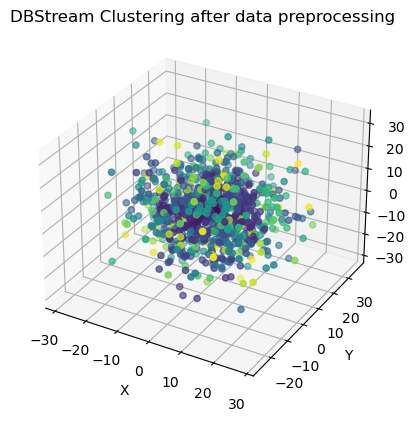

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBStream Clustering after data preprocessing')
ax.scatter(incoming_3d_data[:, 0], incoming_3d_data[:, 1], incoming_3d_data[:, 2], c=y_pred)
#print(f'Accuracy {accuracy_score(y_pred, labels_inj_rand)*100} %')
plt.show()

(array([ 82., 221., 159., 128.,  91.,  91.,  61.,  65.,  62.,  40.]),
 array([  1. ,  30.2,  59.4,  88.6, 117.8, 147. , 176.2, 205.4, 234.6,
        263.8, 293. ]),
 <BarContainer object of 10 artists>)

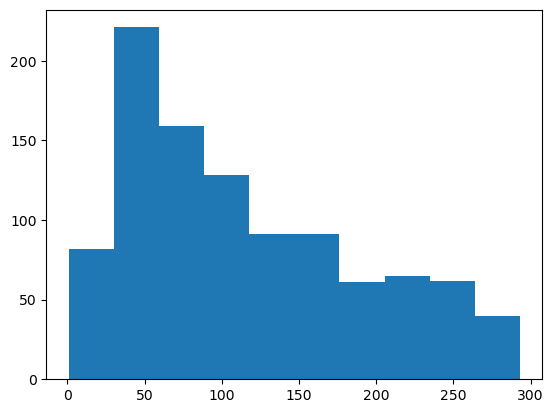

In [ ]:
plt.hist(y_pred)

In [ ]:
dbstream_exp.n_clusters

291

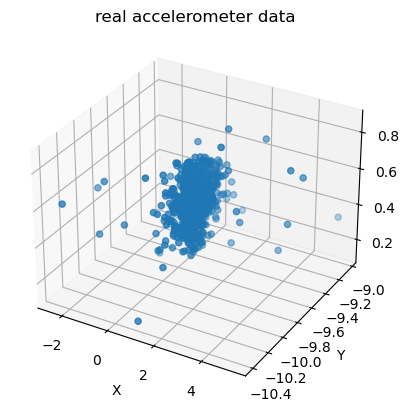

In [ ]:
test_data = pd.read_csv("test data1.csv").to_numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('real accelerometer data')
ax.scatter(test_data[:, 0], test_data[:, 1], test_data[:, 2])
#print(f'Accuracy {accuracy_score(y_pred, labels_inj_rand)*100} %')
plt.show()

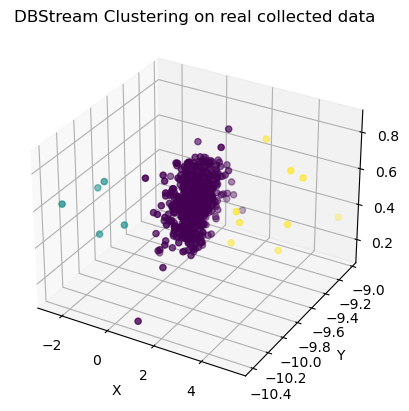

In [ ]:
dbstream_real = cluster.DBSTREAM(clustering_threshold = 2)
y_pred = np.zeros(len(test_data),)
for i, (x, _) in enumerate(stream.iter_array(test_data)):
    dbstream_real = dbstream_real.learn_one(x)
    y_pred[i] = dbstream_real.predict_one(x)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBStream Clustering on real collected data')
ax.scatter(test_data[:, 0], test_data[:, 1], test_data[:, 2], c=y_pred)
#print(f'Accuracy {accuracy_score(y_pred, labels_inj_rand)*100} %')
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

n_features = 3
# Flatten the time series data
data_flat = test_data.reshape(-1, n_features)

# Normalize the flattened data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_flat)

# Tokenize the flattened data
tokenized_data = data_normalized.tolist()



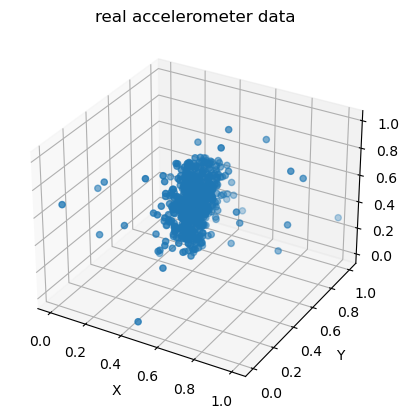

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('real accelerometer data')
ax.scatter(data_normalized[:, 0], data_normalized[:, 1], data_normalized[:, 2])
#print(f'Accuracy {accuracy_score(y_pred, labels_inj_rand)*100} %')
plt.show()

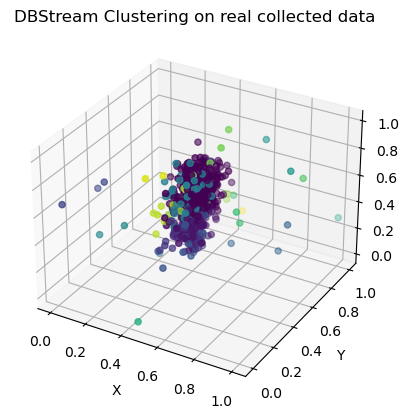

In [ ]:
dbstream_real = cluster.DBSTREAM(clustering_threshold = 0.25)
y_pred = np.zeros(len(data_normalized),)
for i, (x, _) in enumerate(stream.iter_array(data_normalized)):
    dbstream_real = dbstream_real.learn_one(x)
    y_pred[i] = dbstream_real.predict_one(x)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBStream Clustering on real collected data')
ax.scatter(data_normalized[:, 0], data_normalized[:, 1], data_normalized[:, 2], c=y_pred)
#print(f'Accuracy {accuracy_score(y_pred, labels_inj_rand)*100} %')
plt.show()

In [ ]:
data.head()

,0,1,2
0,-0.797681,-9.545238,0.219616
1,-0.793492,-9.549427,0.207648
2,-0.774941,-9.564985,0.244151
3,-0.795287,-9.561395,0.206451
4,-0.796484,-9.545836,0.203459


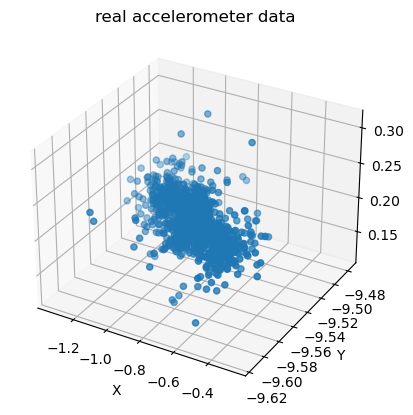

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('real accelerometer data')
ax.scatter(data[0], data[1], data[2])
#print(f'Accuracy {accuracy_score(y_pred, labels_inj_rand)*100} %')
plt.show()

In [ ]:
def create_labels(true_pr, data):
    len_of_true = int(len(data)*true_pr)
    len_of_fal = len(data) - len_of_true
    y_proper = np.full((len_of_true,), True)
    y_anomalous = np.full((len_of_fal,), False)
    y_train = np.concatenate((y_proper, y_anomalous))
    return y_train

In [ ]:
ground_truth = create_labels(0.4, data)

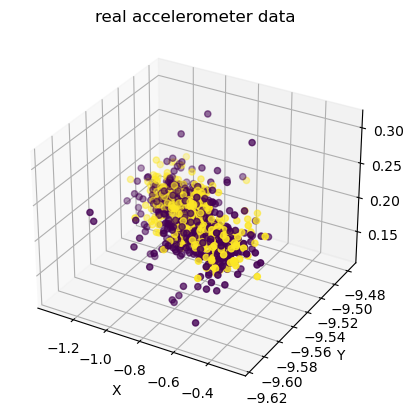

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('real accelerometer data')
ax.scatter(data[0], data[1], data[2], c = ground_truth)
#print(f'Accuracy {accuracy_score(y_pred, labels_inj_rand)*100} %')
plt.show()